**Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Download U2Net repo**

In [2]:
%cd /content/drive/MyDrive
import os
if not os.path.exists("/content/drive/MyDrive/U-2-Net/"):
    !git clone https://github.com/xuebinqin/U-2-Net.git

%cd /content/drive/MyDrive/U-2-Net/

/content/drive/MyDrive
/content/drive/MyDrive/U-2-Net


**Generate training images from labelled json file and augment the dataset**

In [ ]:
!python3 generate_training_dataset.py

In [ ]:
!python3 augment_dataset.py

In [ ]:
%cd /content/drive/MyDrive/U-2-Net/
! mkdir saved_models/u2net/
%cd /content/drive/MyDrive/U-2-Net/saved_models/u2net/
!gdown https://drive.google.com/u/0/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&export=download

/content/drive/MyDrive/U-2-Net
mkdir: cannot create directory ‘saved_models/u2net/’: File exists
/content/drive/MyDrive/U-2-Net/saved_models/u2net
'uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ'
Downloading...
From: https://drive.google.com/u/0/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/drive/MyDrive/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:05<00:00, 32.8MB/s]


**Train U2NET**

In [ ]:
%cd /content/drive/MyDrive/U-2-Net/
!python3 u2net_train.py

Streaming output truncated to the last 5000 lines.

[epoch: 21518/100000, batch:    24/   30, ite: 172142] train loss: 0.310622, tar: 0.015455 
It 172142
l0: 0.011394, l1: 0.011396, l2: 0.012401, l3: 0.013156, l4: 0.016660, l5: 0.050542, l6: 0.200185

[epoch: 21518/100000, batch:    28/   30, ite: 172143] train loss: 0.310658, tar: 0.015426 
It 172143
l0: 0.059140, l1: 0.059306, l2: 0.060257, l3: 0.064607, l4: 0.073658, l5: 0.139470, l6: 0.300258

[epoch: 21518/100000, batch:    32/   30, ite: 172144] train loss: 0.313755, tar: 0.015730 
It 172144
l0: 0.007343, l1: 0.007340, l2: 0.008162, l3: 0.009313, l4: 0.011353, l5: 0.023670, l6: 0.121169

[epoch: 21519/100000, batch:     4/   30, ite: 172145] train loss: 0.312890, tar: 0.015672 
It 172145
l0: 0.007669, l1: 0.007667, l2: 0.008376, l3: 0.008836, l4: 0.010336, l5: 0.030820, l6: 0.140726

[epoch: 21519/100000, batch:     8/   30, ite: 172146] train loss: 0.312216, tar: 0.015617 
It 172146
l0: 0.010274, l1: 0.010271, l2: 0.011085, l3: 

**Preprocess test samples and inferece the U2Net model**

In [4]:
import matplotlib.pyplot as plt

def show(image, **kwargs):
    import matplotlib.pyplot as plt
    plt.imshow(image, cmap=plt.cm.gray, **kwargs)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])

def get_contour(mask,change_color=True, thresh_value=[10,255]):
    
    if  change_color:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    (thresh, mask) = cv2.threshold(mask, thresh_value[0], thresh_value[1], 0)
    try:
        (_, contours, hierarchy) = cv2.findContours(image = mask, 
            mode = cv2.RETR_TREE,
            method = cv2.CHAIN_APPROX_SIMPLE)
    except:
        (contours, hierarchy) = cv2.findContours(image = mask, 
            mode = cv2.RETR_TREE,
            method = cv2.CHAIN_APPROX_SIMPLE)        

    contours_sizes= [(cv2.contourArea(cnt), cnt) for cnt in contours]
    biggest_contour = max(contours_sizes, key=lambda x: x[0])[1]
    (x,y,w,h) = cv2.boundingRect(biggest_contour)
    b_box = [x,y,x+w,y+h]
    
    max_distance = 0
    farthest_points = []

    for contour in contours:
        for point1 in contour:
            for point2 in contour:
                distance = np.linalg.norm(point1 - point2)
                if distance > max_distance:
                    max_distance = distance
                    farthest_points = [point1[0], point2[0]]

    return biggest_contour,b_box, farthest_points



def crop_marked_region(img, source_img):
    org = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,2,255,0)
    not_img = cv2.bitwise_not(thresh)
    contour, box, far_points = get_contour(not_img, change_color=False)
    
    dx = far_points[1][0] -  far_points[0][0]
    dy = far_points[1][1] -  far_points[0][1]
    radians = math.atan2(dy, dx)
    angle = math.degrees(radians)

    rotated = imutils.rotate(source_img, angle)    
    center = (rotated.shape[1] // 2, rotated.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_far_points = cv2.transform(np.array([far_points]), rotation_matrix)[0]

    length_line = abs(rotated_far_points[0][0] - rotated_far_points[1][0])    
    x1 =  rotated_far_points[0][0] -50
    x2 = rotated_far_points[1][0]
    y1 = rotated_far_points[0][1]- int( length_line/2) 
    y2 = rotated_far_points[1][1] -10
    y1 = y2 - int(length_line*0.5)
    cropped = rotated[y1:y2 ,x1:x2]
    return cropped

In [6]:
%cd /content/drive/MyDrive/U-2-Net/
import os
import imutils
from skimage import io, transform
import torch
import torchvision
import math 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
# import torch.optim as optim

import numpy as np
from PIL import Image
import glob
import random 

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB
from PIL import Image
from skimage import io
import cv2
# normalize the predicted SOD probability map

def get_random_rgb():
    r = random.randrange(256)  # Random value for red (0-255)
    g = random.randrange(256)  # Random value for green (0-255)
    b = random.randrange(256)  # Random value for blue (0-255)
    return (r, g, b)  # Return the RGB color tuple


transform_=transforms.Compose([RescaleT(320), ToTensorLab(flag=0)])

def image_loader(image):
    """load image, returns cuda tensor"""
 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample = {'imidx':np.array([0]), 'image':image, 'label':image}
    shape= image.shape
    sample = transform_(sample)   # Perform rescale and color  format conversion RGB to tensorlab
    image = sample['image']
    image  = torch.unsqueeze(image,0)

    return image,[shape[1],shape[0],3] #assumes that you're using GPU


def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn


def main(net, img_original):
    original = img_original.copy()
    imgx = img_original.copy()
    inputs_test, im_size = image_loader(imgx)
    bk = np.full(img_original.shape, 255, dtype=np.uint8)  # white bk, same size and type of image

    inputs_test = inputs_test.type(torch.FloatTensor)
    
    inputs_test = Variable(inputs_test)

    d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

    pred = d4[:,0,:,:]
    pred = normPRED(pred)

    predict = pred.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')

    img = im.resize((im_size[0],im_size[1]),resample=Image.BILINEAR)

    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray,1, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return mask 


if __name__ == "__main__":

    model_name='u2net'

    model_dir = "/content/drive/MyDrive/U-2-Net/trained_models/capillaries_segmentation.pth"

    net = U2NET(3,1)
   
    #net.load_state_dict(torch.load(model_dir))
    device = torch.device('cpu')
    net.load_state_dict(torch.load(model_dir,map_location=device))
    #if torch.cuda.is_available():
        #net.cuda()
    net.eval()

    output_folder =  "/content/drive/MyDrive/U-2-Net/capilaeries_output/"
    if not os.path.exists(output_folder):
      os.makedirs(output_folder)
    img_folder = "/content/drive/MyDrive/U-2-Net/test_images/"
    overlayed_images = []
    masks = []
    eroded_images = []
    final_masks = []
    for file in sorted(os.listdir(img_folder)):
        if "Natif" not in file:
          filepath = img_folder+file
          filename, ext = os.path.splitext(file)
          outfile = output_folder+filename+"_mask"+".jpg"          
          outfile_eroded = output_folder+filename+"_eroded_mask"+".jpg"
          outfile_preprocessed = output_folder+filename+"_preprocessed"+".jpg"
          outfile_canvas = output_folder+filename+"_canvas"+".jpg"

          img = cv2.imread(filepath)

          source_img_file = filepath.replace(".jpg","_Natif.jpg")

          source_img = cv2.imread(source_img_file)
          cropped_image = crop_marked_region(img.copy(), source_img)
          outfile_cropped = output_folder+filename+"_cropped"+".jpg"
          cv2.imwrite(outfile_cropped, cropped_image)

          green_channel = cropped_image[:,:,1]
          blurred = cv2.GaussianBlur(green_channel.copy(), (5, 5), 0)
          filtered_median  = cv2.medianBlur(blurred, 3)
          cv2.imwrite(outfile_preprocessed,filtered_median)

          
          canvas = cv2.cvtColor(filtered_median, cv2.COLOR_GRAY2BGR)


          mask = main(net, filtered_median)
          cv2.imwrite(outfile,mask)

          masks.append(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))

          kernel = np.ones((5, 5), np.uint8)

          eroded = cv2.erode(mask, kernel, iterations=2)

          cv2.imwrite(outfile_eroded,eroded)

          eroded_images.append(eroded)



          contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          contours = sorted(contours, key=cv2.contourArea, reverse=True)

          c= 0

          colors = [(0, 255, 0), (255, 0, 0),(0, 0, 255), [255, 255, 0], [255, 0, 255], [0, 255, 255]]  # Green color for the overlay
          alpha = 1 # Overlay transparency (adjust as needed)

          final_mask =  np.zeros_like(mask)


          threshold_area = 100
          for contour in contours:
              area = cv2.contourArea(contour)
              if area > threshold_area:
                  overlay = canvas.copy()
                  mask_ = np.zeros_like(mask)
                  cv2.drawContours(mask_, [contour], 0, (255, 255, 255), -1)  # Red color is used here, but you can change it
                  cv2.drawContours(final_mask, [contour], 0, (255, 255, 255), -1)  # Red color is used here, but you can change it

                  overlay[mask_ > 0] = get_random_rgb()

                  canvas = cv2.addWeighted(canvas, 1 - alpha, overlay, alpha, 0)


                  c +=1

          cv2.imwrite(outfile_canvas, canvas)
          print(f'{filename} Number of capilaries: {c}')
          overlayed_images.append(canvas)
          final_masks.append(cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR))
        

/content/drive/MyDrive/U-2-Net
N1a Number of capilaries: 5
N1b Number of capilaries: 7
N1c Number of capilaries: 9
N1d Number of capilaries: 8
N1e Number of capilaries: 8
N1f Number of capilaries: 8
N1g Number of capilaries: 8
N1h Number of capilaries: 7
N1i Number of capilaries: 7
N1j Number of capilaries: 8
N2b Number of capilaries: 10
N2c Number of capilaries: 9
N2d Number of capilaries: 6
S2a Number of capilaries: 1
S2b Number of capilaries: 2
S2c Number of capilaries: 2
S2d Number of capilaries: 5
S2e Number of capilaries: 3
S2f Number of capilaries: 1
S2g Number of capilaries: 4
S3a Number of capilaries: 5
S3b Number of capilaries: 4
S3c Number of capilaries: 2
S3d Number of capilaries: 4
S3e Number of capilaries: 5
S3f Number of capilaries: 4
S3g Number of capilaries: 5
S3h Number of capilaries: 4
S3i Number of capilaries: 2
S3j Number of capilaries: 5


**Visualize the results**

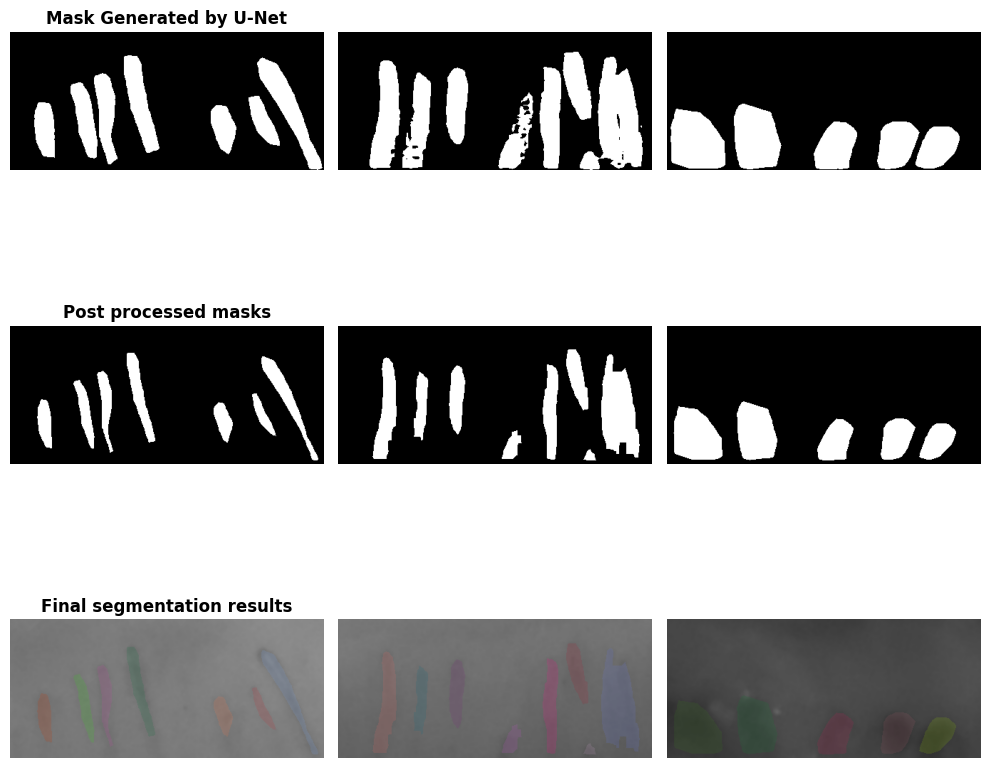

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

images = [masks[1], masks[6], masks[24],
          final_masks[1], final_masks[6], final_masks[24],
          overlayed_images[1], overlayed_images[6], overlayed_images[24]]
# Iterate over the subplot grid, display the images, and add labels
row_labels = ["Mask Generated by U-Net",
              "Post processed masks",
              "Final segmentation results"]

# Iterate over the subplot grid, display the images, and add row labels
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i])
    ax.axis('off')

    # Add row label only to the first image of each row
    if i % 3 == 0:
        ax.set_title(row_labels[i // 3], fontsize=12, fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the grid of images
plt.show()